In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE


## Requirements

In [4]:
# Transformers installation
! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git


     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 45.8 MB/s 
     |████████████████████████████████| 596 kB 60.2 MB/s 
     |████████████████████████████████| 895 kB 65.1 MB/s 
     |████████████████████████████████| 77 kB 9.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import torch

In [7]:
MODELNAME = 'biodivbert-abstracts'
DATASETNAME = 'GAD'

In [8]:
MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/models/biodivbert-abstracts"

In [9]:
tokenizer_name = 'bert-base-cased'

In [10]:
num_train_epochs = 5

In [11]:
MODEL_PATH

'/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/models/biodivbert-abstracts'

In [12]:
num_train_epochs

5

## Dataset Preprocessing


Dataset config file

In [13]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

root_data_dir = os.path.join(root_dir, "datasets", "GAD")
print(root_data_dir)

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/datasets/GAD


Data loading utils

In [14]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col)
  data = data.fillna(method="ffill")
  return data

In [15]:
data_train = loadData(csv_file_path='train.csv', header=0, index_col=None)

In [16]:
data_train.head(10)

,sentence,label
0,this study proposes that A/A genotype at posit...,1
1,Common polymorphisms in the genes @GENE$ and L...,1
2,Results do not support any overall association...,1
3,@GENE$ methylation occurs frequently in human ...,0
4,"In conclusion, @GENE$ 8092C > A polymorphism m...",1
5,Allele A in @GENE$ gene +252 site can signific...,1
6,Our data indicate that the -160 single nucleot...,1
7,These results suggest that the @GENE$/-159 pol...,0
8,there is no evidence for an association of @GE...,1
9,The association between the @GENE$ G allele an...,1


In [17]:
data_dev = loadData(csv_file_path='dev.csv', header=0, index_col=None)

In [18]:
data_dev.head(10)

,sentence,label
0,"Deteriorating gallbladder contractions, possib...",1
1,Our results do not indicate an effect of @GENE...,0
2,It is unlikely that the promoter polymorphisms...,1
3,Although the effects of the A(-173) allele wer...,0
4,Variation in the preproghrelin gene is not ass...,0
5,"In conclusion, our findings support the hypoth...",0
6,The results of this study link @GENE$ (@DISEAS...,0
7,The deletion mutation in exon 11 in @GENE$ gen...,1
8,These data suggest that @GENE$ variation contr...,1
9,The results indicate that @GENE$(V617F) @DISEA...,0


In [19]:
data_test = loadData(csv_file_path='test.csv', header=0, index_col=None)

In [20]:
data_test.head(10)

,sentence,label
0,Our findings indicate that the @GENE$ @DISEASE...,0
1,The results suggest that the @GENE$ gene may n...,0
2,These results suggest that unlike for other ca...,1
3,Our findings suggest that the @GENE$-repeat po...,0
4,The findings of this large study strongly supp...,0
5,These studies support that @GENE$ mutations ar...,0
6,These results suggest that @GENE$ variants may...,1
7,The data obtained in the present study strengt...,0
8,We observed that @GENE$ G395A polymorphism was...,0
9,Our results provide no evidence for an associa...,1


In [21]:
print(len(data_train), len(data_dev) , len(data_test))

4097 513 512


split texts and labels

In [22]:
train_texts = data_train[data_train.columns[0]].to_list()
train_labels = data_train[data_train.columns[1]].to_list()  

In [23]:
dev_texts = data_dev[data_dev.columns[0]].to_list()
dev_labels = data_dev[data_dev.columns[1]].to_list()

In [24]:
test_texts = data_test[data_test.columns[0]].to_list()
test_labels = data_test[data_test.columns[1]].to_list()

Some visualizations useful for max_len determination, BERT in all cases is limited to 512 word input. After running the below cells, some sentenaces exceeded this limit, we will need truncation during the tokenizer step

In [25]:
plt.style.use("ggplot")

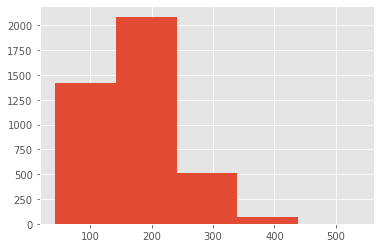

In [26]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [27]:
max([len(s) for s in train_texts]) # we will need truncation (automatically on token encodings and manually in the encode_labels function)

538

In [28]:
max([len(s) for s in test_texts])

396

Tokenization

In [29]:
from transformers import BertTokenizerFast, DistilBertTokenizerFast
print(tokenizer_name)
if 'dist' in tokenizer_name:
  tokenizer = DistilBertTokenizerFast.from_pretrained(tokenizer_name)
else:
  tokenizer = BertTokenizerFast.from_pretrained(tokenizer_name)

bert-base-cased


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [30]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True)
dev_encodings = tokenizer(dev_texts, padding=True, truncation=True)
test_encodings = tokenizer(test_texts, padding=True, truncation=True)

### Dataset objects 

Create the dataset objects

In [31]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [32]:
# train_encodings.pop("offset_mapping") # we don't want to pass this to the model
# test_encodings.pop("offset_mapping")

In [33]:
train_dataset = MyDataset(train_encodings, train_labels)
dev_dataset = MyDataset(dev_encodings, test_labels)
test_dataset = MyDataset(test_encodings, test_labels)

### Training

Here, we instantiate the model

In [34]:
from transformers import DistilBertForSequenceClassification, BertForSequenceClassification
if 'dist' in MODELNAME:
  model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)
else:
  model = BertForSequenceClassification.from_pretrained(MODEL_PATH)

Some weights of the model checkpoint at /content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/models/biodivbert-abstracts were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not ini

#### Fine-tuning using Trainer

In [35]:
from sklearn.metrics import accuracy_score
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # print(labels)
    # print(predictions)
    # Remove ignored index (special tokens)
    # Create a long 1D list of y_true and y_pred
    y_true = []
    y_pred = []
    for pred, lbl in zip(predictions, labels):  
      y_true.append(lbl) 
      y_pred.append(pred)    
    acc = accuracy_score(y_true, y_pred)
    return {    # we can customize this dictionary to include Pr, Recall and F1-Score as well.
        "accuracy": acc,
    }

In [36]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=num_train_epochs, # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "epoch",
  )

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset  
    eval_dataset=dev_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,      
    
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4097
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1285


Epoch,Training Loss,Validation Loss,Accuracy
1,0.636800,0.947026,0.494141
2,0.534400,1.100561,0.513672
3,0.445800,1.278894,0.511719
4,0.283600,1.730138,0.525391
5,0.248300,2.062150,0.515625


***** Running Evaluation *****
  Num examples = 512
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 512
  Batch size = 64
***** Running Evaluation *****
  Num examples = 512
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 512
  Batch size = 64
***** Running Evaluation *****
  Num examples = 512
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1285, training_loss=0.42530095373146265, metrics={'train_runtime': 386.6876, 'train_samples_per_second': 52.976, 'train_steps_per_second': 3.323, 'total_flos': 1557997725428400.0, 'train_loss': 0.42530095373146265, 'epoch': 5.0})

### Save model

In [37]:
model.save_pretrained('{}_{}'.format(MODELNAME, DATASETNAME))

Configuration saved in biodivbert-abstracts_GAD/config.json
Model weights saved in biodivbert-abstracts_GAD/pytorch_model.bin


### Prediction

The use of validation dataset

In [38]:
eval_history = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 512
  Batch size = 64


In [39]:
predictionsOutput = trainer.predict(test_dataset) 

***** Running Prediction *****
  Num examples = 512
  Batch size = 64


In [40]:
predictionsOutput.predictions.shape

(512, 2)

In [41]:
predictions = predictionsOutput.predictions.argmax(axis=1)

In [42]:
predictions.shape # each of the corresponding tokens has one label which has the highest propability

(512,)

Explore one example of the test dataset (prediction vs. true) lables.

In [43]:
for text, pred, lbl in zip(test_texts, predictions, test_labels):
  print(pred, text)
  print(lbl, text)
  break

0 Our findings indicate that the @GENE$ @DISEASE$ polymorphism may not be associated with risk of lung cancer in the Chinese population.
0 Our findings indicate that the @GENE$ @DISEASE$ polymorphism may not be associated with risk of lung cancer in the Chinese population.


### Evaluation Metrcies 

F1-Score, Precision and Recall, sklearn?

In [44]:
# Create a long 1D list of y_true and y_pred
y_true = []
y_pred = []

for text, pred, lbl in zip(test_texts, predictions, test_labels):
  y_true.append(lbl)
  y_pred.append(pred)

In [45]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.76171875


In [46]:
from sklearn.metrics import precision_recall_fscore_support

In [47]:
precision_recall_fscore_support(y_true, y_pred,labels=[0,1])

(array([0.82159624, 0.71906355]),
 array([0.67567568, 0.84980237]),
 array([0.74152542, 0.77898551]),
 array([259, 253]))

In [48]:
from classification_metrics import classification_report

In [49]:
print(classification_report(y_true, y_pred,exclude_non_entity=True))

                        precision 	 recall 	 f1-score 	 support

                   0	 0.82		 0.68		 0.74		 259	
                   1	 0.72		 0.85		 0.78		 253	


macro avg           	 0.77		 0.76		 0.77		 512	
micro avg           	 0.76		 0.76		 0.76		 512	



### Visualizations
Plots of learning curves (loss and accuracy) during training and validation

In [50]:
def plot_dict(history, start_step=10,  step_size=10, use_title=None, use_xlabel=None, use_ylabel=None):
  plt.figure(figsize=(12,12))
  for key, list_val in history.items():
    plt.plot(list_val, label=key)
  plt.title(use_title)
  plt.xlabel(use_xlabel)
  plt.ylabel(use_ylabel, multialignment='center')
  plt.legend()
  plt.show()

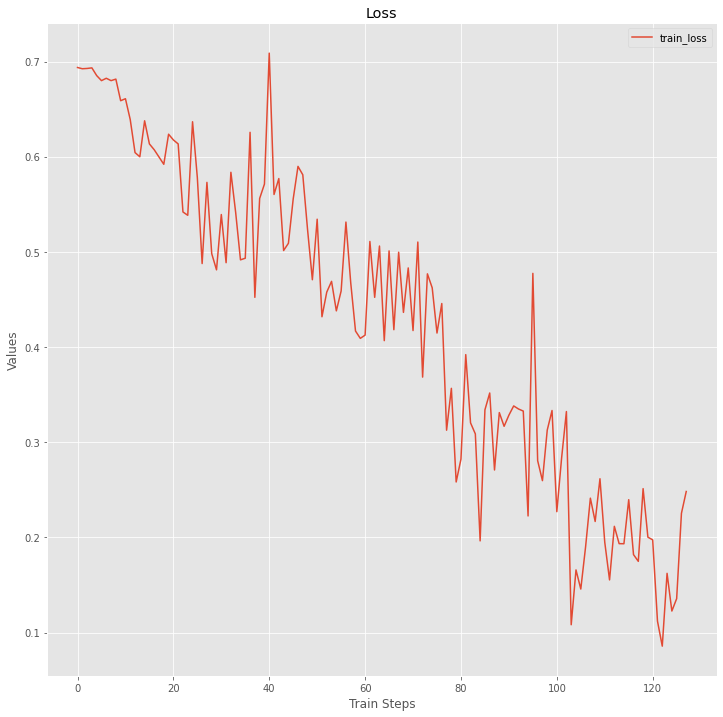

In [51]:
# Keep track of train and evaluate loss.
# loss_history = {'train_loss':[], 'eval_loss':[]}
loss_history = {'train_loss':[]}

# Keep track of train and evaluate accuracy
acc_history = {'train_acc':[], 'eval_acc':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with trianing/eval loss.
    loss_history['train_loss'].append(log_history['loss'])
    #loss_history['eval_loss'].append(log_history['eval_loss'])
    
  elif 'acc' in log_history.keys():
    # Deal with training/eval accuracy.
    loss_history['train_acc'].append(log_history['acc'])
    loss_history['eval_acc'].append(log_history['eval_acc'])

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values')

In [52]:
eval_history

{'epoch': 5.0,
 'eval_accuracy': 0.515625,
 'eval_loss': 2.062150478363037,
 'eval_runtime': 2.4893,
 'eval_samples_per_second': 205.678,
 'eval_steps_per_second': 3.214}

# Prediction

https://huggingface.co/docs/transformers/v4.17.0/en/task_summary#sequence-classification

In [53]:
model = BertForSequenceClassification.from_pretrained('{}_GAD'.format(MODELNAME))
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

loading configuration file biodivbert-abstracts_GAD/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/models/biodivbert-abstracts",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file biodivbert-abstracts_GAD/pytorch_model.bin
All model checkpoint weights were used when initializin

In [54]:
sequence = '@QUALITY$ of the @ORGANISM$ is measured vertically.'

In [55]:
classes = ["True", "False"]

In [56]:
true_sent = tokenizer(sequence, return_tensors="pt")

In [57]:
classification_logits = model(**true_sent).logits

In [58]:
results = torch.softmax(classification_logits, dim=1).tolist()[0]

In [59]:
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(results[i] * 100))}%")

True: 100%
False: 0%


In [60]:
classification_logits

tensor([[ 3.0405, -3.2427]], grad_fn=<AddmmBackward0>)